In [1]:
# Import all libraries 
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
import os

load_dotenv()

client_id = os.getenv('api_key') 
client_secret = os.getenv('secret')
auth_url = 'https://api.petfinder.com/v2/oauth2/token'
auth_data = {
    'grant_type': 'client_credentials',
    'client_id': client_id,
    'client_secret': client_secret
}

response = requests.post(auth_url, data=auth_data)
token = response.json().get('access_token')


In [2]:
headers = {
    'Authorization': f'Bearer {token}'
}
params = {
    'location': '84606',
    'distance': 100,
    'limit': 50           
}

# Fetch multiple pages
all_animals = []
page = 1
max_pages = 8

while page <= max_pages:
    params['page'] = page
    response = requests.get('https://api.petfinder.com/v2/animals', headers=headers, params=params)

    if response.status_code == 200:
        animals_data = response.json()['animals']
        
        if not animals_data:
            break

        for animal in animals_data:
            record = {
                'organization_id': animal.get('organization_id'),
                'id': animal.get('id'),
                'species': animal.get('species'),
                'name': animal.get('name'),
                'age': animal.get('age'),
                'breed': animal.get('breeds', {}).get('primary'),
                'mixed': animal.get('breeds', {}).get('mixed'),
                'color': animal.get('colors', {}).get('primary'),
                'fixed': animal.get('attributes', {}).get('spayed_neutered'),
                'house_trained': animal.get('attributes', {}).get('house_trained'),
                'good_with_children': animal.get('environment', {}).get('children'),
                'good_with_dogs': animal.get('environment', {}).get('dogs'),
                'good_with_cats': animal.get('environment', {}).get('cats'),
                'gender': animal.get('gender'),
                'distance': animal.get('distance'),
                'url': animal.get('url')            
            }
            all_animals.append(record)
        
        page += 1 
    else:
        print("Error:", response.status_code, response.json())
        break

animals_df = pd.DataFrame(all_animals)


In [3]:
# Need organization names, use other 'organizations' endpoint
org_ids = animals_df['organization_id'].unique()
org_names = {}

for id in org_ids:
    org_response = requests.get(f'https://api.petfinder.com/v2/organizations/{id}', headers=headers)
    if org_response.status_code == 200:
        org_data = org_response.json().get('organization', {})
        org_names[id] = org_data.get('name')
    else:
        print(f"Error fetching organization {id}")


In [4]:
# Add organization name column to animals df
animals_df['organization_name'] = animals_df['organization_id'].map(org_names)
animals_df['organization_name'].unique()

array(['Throw a Dog a Bone Dog Rescue', 'Jason Heigl Foundation',
       'Nuzzles & Co. Adoption Center',
       'Salt Lake County Animal Services', 'FurEverAfter',
       'Kitty CrusAIDe', 'Roosevelt Animal Shelter',
       'Best Friends Animal Society-Utah', 'Desiderata Rescue',
       'True Hearts Rescue for Healing Paws',
       'Community Animal Welfare Society (CAWS)',
       'Second Chance for Homeless Pets', 'Whiskers',
       'Great Pyrenees Rescue Resources Utah Montana',
       'Humane Society of Utah', 'Davis County Animal Services',
       'Hearts 4 Paws', 'Utah Valley Animal Rescue, Inc.',
       'Celestial Zoo Pet Rescue', 'Rescue Rovers Dog Adoptions',
       'Wasatch Wanderers', 'Furever Friends Animal Oasis',
       'The Golden Bark Foundation', 'Herding Haven',
       'Humane Society of Northern Utah',
       'Utah Animal Advocacy Foundation', 'Outreach Pawsabilities',
       'Pet Samaritan Fund', 'Happy Tails at Pegasus',
       'Utah Animal Adoption Center', 'Carbo

In [5]:
# check the shape of the df
animals_df.shape

(400, 17)

In [6]:
# Check datatypes of each column
animals_df.dtypes

organization_id        object
id                      int64
species                object
name                   object
age                    object
breed                  object
mixed                    bool
color                  object
fixed                    bool
house_trained            bool
good_with_children     object
good_with_dogs         object
good_with_cats         object
gender                 object
distance              float64
url                    object
organization_name      object
dtype: object

In [7]:
# Summary statistics dictionary
summary_stats = {
    'Total Animals': len(animals_df),
    'Species Distribution': animals_df['species'].value_counts(),
    'Age Groups': animals_df['age'].value_counts(),
    'Most Common Breeds': animals_df['breed'].value_counts().head(),
    'Gender Distribution': animals_df['gender'].value_counts(normalize=True),
    'Percentage of Animals Fixed': (animals_df['fixed'] == True).mean() * 100,
    'House Trained Percentage': (animals_df['house_trained'] == True).mean() * 100,
    'Most Common Colors': animals_df['color'].value_counts().head(),
    'Organizations Count': animals_df['organization_name'].nunique()
}

print(summary_stats)

{'Total Animals': 400, 'Species Distribution': species
Cat       205
Dog       189
Rabbit      4
Duck        1
Rat         1
Name: count, dtype: int64, 'Age Groups': age
Baby      137
Adult     133
Young     112
Senior     18
Name: count, dtype: int64, 'Most Common Breeds': breed
Domestic Short Hair     153
Domestic Medium Hair     28
Mixed Breed              25
Domestic Long Hair       16
Chihuahua                16
Name: count, dtype: int64, 'Gender Distribution': gender
Female    0.5075
Male      0.4925
Name: proportion, dtype: float64, 'Percentage of Animals Fixed': 77.75, 'House Trained Percentage': 30.0, 'Most Common Colors': color
Black                               75
Gray / Blue / Silver                39
Brown / Chocolate                   32
White / Cream                       23
Tricolor (Brown, Black, & White)    19
Name: count, dtype: int64, 'Organizations Count': 37}


In [8]:
# Save animals df as csv
animals_df.to_csv('animals_data.csv')

In [9]:
traits_no_df = animals_df.dropna(subset=['good_with_dogs', 'good_with_cats', 'good_with_children']) 

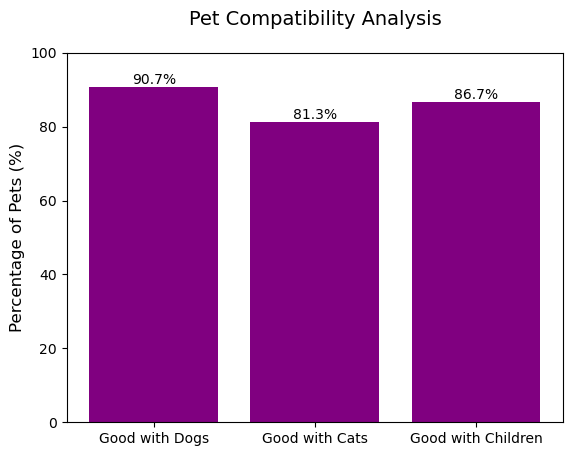

In [10]:
def plot_pet_compatibility(df):
    # Calculate the proportions
    proportions = {
        'Good with Dogs': (df['good_with_dogs'] == True).mean() * 100,
        'Good with Cats': (df['good_with_cats'] == True).mean() * 100,
        'Good with Children': (df['good_with_children'] == True).mean() * 100
    }
    
    plt.figure()

    bars = plt.bar(proportions.keys(), proportions.values(), color = 'purple')
    
    # Customize the plot
    plt.title('Pet Compatibility Analysis', fontsize=14, pad=20)
    plt.ylabel('Percentage of Pets (%)', fontsize=12)
    
    # Add percentage labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom')
    
    # Set y-axis to go from 0 to 100
    plt.ylim(0, 100)
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=0)
    return plt


plot_pet_compatibility(traits_no_df)
plt.show()

Text(0, 0.5, 'Count of Animals')

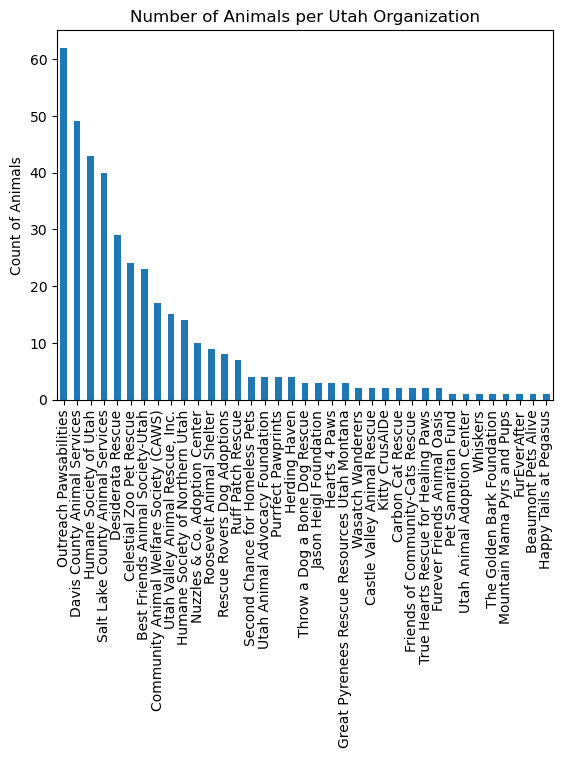

In [11]:
#EDA
count_by_org = animals_df['organization_name'].value_counts()
count_by_org.plot(kind = 'bar')
plt.title("Number of Animals per Utah Organization")
plt.xlabel('')
plt.ylabel("Count of Animals")


In [12]:
# Calculate cat proportions directly
species_df = animals_df[['organization_name', 'species']]

In [13]:
# Create a copy to avoid modifying the original DataFrame
org_summary = species_df.copy()

# Group by organization and count the number of animals
org_summary['animal_count'] = org_summary.groupby('organization_name').transform('count')


In [14]:
 # Count the number of cat species for each organization
cat_counts = org_summary[org_summary['species'] == 'Cat'].groupby('organization_name').transform('count')
    

In [15]:
# Create a copy to avoid modifying the original DataFrame
org_summary = species_df.copy()

# Group by organization and count the number of animals
org_summary['animal_count'] = org_summary.groupby('organization_name').transform('count')

# Count the number of cat species for each organization
cat_counts = org_summary[org_summary['species'] == 'Cat'].groupby('organization_name')['species'].count()

# Calculate the proportion of cat species
org_summary = org_summary.merge(cat_counts, left_on='organization_name', right_index=True, how='left')
org_summary['cat_proportion'] = (org_summary['species_y'] / org_summary['animal_count']).fillna(0)

# Select only the relevant columns
cat_prop_df = org_summary[['organization_name', 'cat_proportion']].drop_duplicates().dropna().reset_index(drop=True)

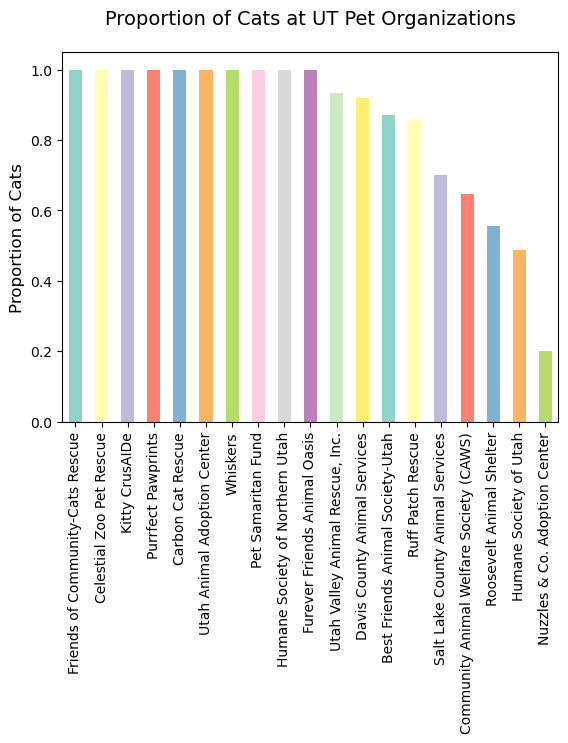

In [16]:
cat_prop_df = cat_prop_df[cat_prop_df['cat_proportion'] != 0].sort_values('cat_proportion', ascending=False)
# Create color palette
colors = sns.color_palette("Set3", len(cat_prop_df))

# Transpose and plot
cat_prop_df.set_index('organization_name')['cat_proportion'].plot(kind='bar', color=colors)

# Customize the plot
plt.title('Proportion of Cats at UT Pet Organizations', fontsize=14, pad=20)
plt.ylabel('Proportion of Cats', fontsize=12)
plt.xlabel('')  # Remove x-axis label

plt.show()